In [405]:
import csv
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch import optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [440]:
def timePointList(dataList, timePointBracket):
    tpList = []
    for i in range(0,int(np.ma.count(dataList)/timePointBracket)):
        if(np.ma.count(dataList) < i*timePointBracket):
            #This is the last iteration
            delta = (dataList[-1] - dataList[(i*timePointBracket)])/(np.ma.count(dataList) - (i*timePointBracket))
            tpList.append(delta)
        else:
            delta = (dataList[(i*timePointBracket) + timePointBracket - 1] - dataList[(i*timePointBracket)])/timePointBracket
            tpList.append(delta)
    return tpList

def generateMotionGraphs(dataX, dataY, dataZ, dataYaw, dataPitch, dataRoll, timepoints):
    deltaX = timePointList(dataX,timepoints)
    deltaY = timePointList(dataY,timepoints)
    deltaZ = timePointList(dataZ,timepoints)
    deltaYaw = timePointList(dataYaw, timepoints)
    deltaPitch = timePointList(dataPitch, timepoints)
    deltaRoll = timePointList(dataRoll, timepoints)

    plt.figure(1)
    plt.plot(deltaX, label = '△X')
    plt.plot(deltaY, label = '△Y')
    plt.plot(deltaZ, label = '△Z')
    plt.title("Body Motion Speed")
    plt.legend()
    plt.savefig("BodyMotion.jpg", dpi=200)

    plt.figure(2)
    plt.plot(deltaYaw, label = '△Yaw')
    plt.plot(deltaPitch, label = '△Pitch')
    plt.plot(deltaRoll, label = '△Roll')
    plt.title("Head Motion Speed")
    plt.legend()
    plt.savefig("HeadMotion.jpg", dpi=200)


In [424]:
def create_dataset1(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

def generateDataset(dataArr, look_back = 125):
    dataset=dataArr.reshape(-1, 1)
    train_size = int(len(dataset) * 0.9)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

    trainX, trainY = create_dataset1(train, look_back)
    testX, testY = create_dataset1(test, look_back)
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    trainX = torch.from_numpy(trainX).float()
    trainY = torch.from_numpy(trainY).float()
    testX = torch.from_numpy(testX).float()
    testY = torch.from_numpy(testY).float()
    return trainX, trainY, testX, testY

In [425]:
class LSTM2(nn.Module):
    def __init__(self, hidden_layers=32, numLayers = 1):
        super(LSTM2, self).__init__()
        self.hidden_layers = hidden_layers
        self.numLayers = numLayers
        self.lstm1 = nn.LSTM(125, self.hidden_layers, batch_first=True, num_layers = numLayers)
        self.linear = nn.Linear(self.hidden_layers, 1)
        
    def forward(self, inputVal):
        hidden_state = torch.randn(self.numLayers, inputVal.size(0), 32).float()
        cell_state = torch.randn(self.numLayers, inputVal.size(0), 32).float()
        hidden = (hidden_state, cell_state)
        h_t, c_t = self.lstm1(inputVal.float(), hidden)
        outputs = self.linear(h_t) # output from the last FC layer
        return outputs

In [426]:
def training_loop(n_epochs, model, optimiser, loss_fn, train_input, train_target):
    model.train()
    trainLoss = []
    train_target = train_target.reshape(train_target.size(0), 1, 1)
    for i in range(n_epochs):
        optimiser.zero_grad()
        out = model(train_input)
        loss = loss_fn(out, train_target)
        loss.backward()    
        optimiser.step()
        trainLoss.append(loss)
        print("Step: {}, Loss: {}".format(i, loss))
    return trainLoss

def eval_model(model, loss_fn, test_input, test_target):
        model.eval()
        test_target = test_target.reshape(test_target.size(0), 1, 1)
        with torch.no_grad():
            pred = model(test_input)
            loss = loss_fn(pred, test_target)
            return loss, pred
        

In [427]:
def trainModel(num_epochs, model, optimiser, criterion, trainX, trainY, plotsFolderName, colName):
    model = model.float()
    train_loss = training_loop(num_epochs, model, optimiser, criterion, trainX, trainY)
    lossArr = []
    for i in range(0,len(train_loss)):
        lossArr.append(train_loss[i].item())
    plt.plot(lossArr, label = "Training Loss")
    plt.legend()
    plt.savefig(plotsFolderName+colName+"trainLoss.jpg", dpi=200)
    plt.close()

In [428]:
def evaluateModel(model, criterion, testX, testY, plotsFolderName, colName):
    test_loss, prediction = eval_model(model, criterion, testX, testY)
    print(test_loss.item())
    plt.figure(figsize=(8, 6), dpi=100)
    plt.scatter(testY, prediction.reshape(prediction.size(0)))
    plt.xlabel("Actual Value")
    plt.ylabel("Predicted Value")
    plt.savefig(plotsFolderName+colName+"scatter.jpg", dpi=200)
    plt.close()

In [444]:
for i in range(1,2):
    fileName = r"dataset/node" + str(i) +  "mobility.csv"
    resultsFolder = r"results/node" + str(i) + "mobility/"
    plotsFolderName = r"results/node" + str(i) + "mobility/plots/"
    df = pd.read_csv (fileName)
    
    for (columnName, columnData) in df.iteritems():
        print("Predicting for " + columnName)
        dataCol = df[columnName].to_numpy()
        trainDataX, trainDataY, testDataX, testDataY = generateDataset(dataCol)
        
        
        
        model = LSTM2(numLayers = 2)
        criterion = nn.MSELoss()
        optimiser = optim.Adam(model.parameters(), lr=0.01)
        trainModel(100, model, optimiser, criterion, trainDataX, trainDataY,plotsFolderName,columnName)
        torch.save(model.state_dict(), resultsFolder+columnName+"savedModel.pt")
        evaluateModel(model, criterion, testDataX, testDataY, plotsFolderName, columnName)

Predicting for X
Step: 0, Loss: 5.614830017089844
Step: 1, Loss: 5.1859846115112305
Step: 2, Loss: 4.768503665924072
Step: 3, Loss: 4.364195346832275
Step: 4, Loss: 3.9673147201538086
Step: 5, Loss: 3.54923677444458
Step: 6, Loss: 3.157418966293335
Step: 7, Loss: 2.8103883266448975
Step: 8, Loss: 2.571552276611328
Step: 9, Loss: 2.451716184616089
Step: 10, Loss: 2.4517149925231934
Step: 11, Loss: 2.479116678237915
Step: 12, Loss: 2.458353281021118
Step: 13, Loss: 2.405954599380493
Step: 14, Loss: 2.1594204902648926
Step: 15, Loss: 1.9372625350952148
Step: 16, Loss: 1.7159708738327026
Step: 17, Loss: 1.9088023900985718
Step: 18, Loss: 1.6413273811340332
Step: 19, Loss: 1.3602757453918457
Step: 20, Loss: 1.3890796899795532
Step: 21, Loss: 1.0823336839675903
Step: 22, Loss: 1.0227386951446533
Step: 23, Loss: 1.2103825807571411
Step: 24, Loss: 1.0066699981689453
Step: 25, Loss: 1.0243884325027466
Step: 26, Loss: 0.9387674331665039
Step: 27, Loss: 0.8737406730651855
Step: 28, Loss: 0.810983

Step: 28, Loss: 0.5503143668174744
Step: 29, Loss: 0.45916375517845154
Step: 30, Loss: 0.43398886919021606
Step: 31, Loss: 0.39148542284965515
Step: 32, Loss: 0.32222387194633484
Step: 33, Loss: 0.26981136202812195
Step: 34, Loss: 0.31274425983428955
Step: 35, Loss: 0.21755513548851013
Step: 36, Loss: 0.1906377226114273
Step: 37, Loss: 0.15057514607906342
Step: 38, Loss: 0.17610879242420197
Step: 39, Loss: 0.1155993789434433
Step: 40, Loss: 0.11426737904548645
Step: 41, Loss: 0.11270327866077423
Step: 42, Loss: 0.13431082665920258
Step: 43, Loss: 0.12303271889686584
Step: 44, Loss: 0.12882661819458008
Step: 45, Loss: 0.11940120905637741
Step: 46, Loss: 0.12503133714199066
Step: 47, Loss: 0.10754174739122391
Step: 48, Loss: 0.10736628621816635
Step: 49, Loss: 0.09623236954212189
Step: 50, Loss: 0.10156770795583725
Step: 51, Loss: 0.08607036620378494
Step: 52, Loss: 0.08692297339439392
Step: 53, Loss: 0.07719844579696655
Step: 54, Loss: 0.07926513254642487
Step: 55, Loss: 0.0735099017620

Step: 70, Loss: 25.630109786987305
Step: 71, Loss: 27.742002487182617
Step: 72, Loss: 25.1702880859375
Step: 73, Loss: 25.058895111083984
Step: 74, Loss: 24.302114486694336
Step: 75, Loss: 25.465932846069336
Step: 76, Loss: 25.159027099609375
Step: 77, Loss: 25.5786075592041
Step: 78, Loss: 25.02780532836914
Step: 79, Loss: 24.551801681518555
Step: 80, Loss: 23.34682273864746
Step: 81, Loss: 23.785512924194336
Step: 82, Loss: 22.5103702545166
Step: 83, Loss: 21.99100112915039
Step: 84, Loss: 20.97347640991211
Step: 85, Loss: 21.799989700317383
Step: 86, Loss: 23.564401626586914
Step: 87, Loss: 21.69091033935547
Step: 88, Loss: 21.531038284301758
Step: 89, Loss: 21.36937141418457
Step: 90, Loss: 23.546030044555664
Step: 91, Loss: 21.580820083618164
Step: 92, Loss: 23.98369789123535
Step: 93, Loss: 25.0817928314209
Step: 94, Loss: 25.462038040161133
Step: 95, Loss: 23.69675636291504
Step: 96, Loss: 24.99898338317871
Step: 97, Loss: 24.336790084838867
Step: 98, Loss: 22.85238265991211
Ste

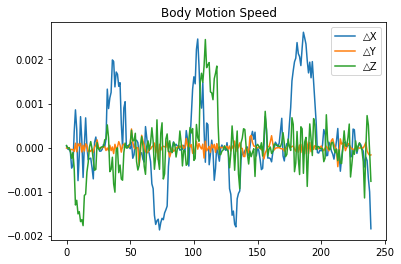

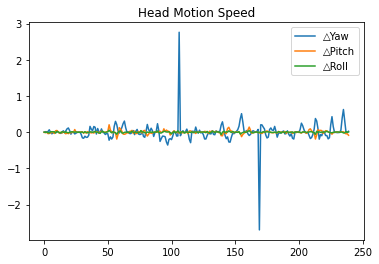

In [441]:
df = pd.read_csv (r"dataset/node1mobility.csv")

dataX = df['X'].to_numpy()
dataY = df['Y'].to_numpy()
dataZ = df['Z'].to_numpy()
dataYaw = df['Yaw'].to_numpy()
dataPitch = df['Pitch'].to_numpy()
dataRoll = df['Roll'].to_numpy()

generateMotionGraphs(dataX, dataY, dataZ, dataYaw, dataPitch, dataRoll, 125)